# ARR Customer Segment Analysis Plan

## Major Assumptions
ARR = MRR × 12. Tracking trends by subscription start month. Segment definitions: startup, mid_market, enterprise. NRR calculated as (starting ARR + expansions - contractions - churn) / starting ARR over a cohort period. Pipeline coverage = open pipeline / won revenue (proxy for quota).

## Plan
- [x] Extract and explore ARR data by customer segment
  - [x] Query ARR broken down by segment and time period
  - [x] Validate segment classifications and identify any data gaps
- [x] Calculate enterprise mix metrics and trends
  - [x] Compute enterprise ARR as percentage of total ARR per period
  - [x] Analyze segment growth rates and contribution to overall ARR growth
- [x] Visualize segment trends and deliver insights
  - [x] Create time series visualization of segment mix evolution
  - [x] Summarize key findings on enterprise concentration trajectory
- [x] Analyze AI product adoption impact on expansion revenue
  - [x] Join product_usage with opportunities to link usage to expansion deals
  - [x] Quantify correlation between AI feature adoption and expansion revenue outcomes
- [x] Calculate Net Revenue Retention by segment
  - [x] Track MRR changes per account to identify expansions, contractions, and churn
  - [x] Compute NRR by segment and visualize retention patterns
- [x] Analyze pipeline coverage and stage conversion by segment
  - [x] Calculate pipeline coverage ratio by segment using opportunities data
  - [x] Examine stage-to-stage conversion rates to identify where deals stall
  - [x] Create visualizations showing bottlenecks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (12, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
          'blue': '#73acfb', 'yellow': '#fec163', 'green': '#4ca86f'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Retool database
engine = create_engine(os.environ['RETOOL_CONNECTION_URL'])

# Query ARR by segment with subscription start dates
query = """
SELECT 
    a.segment,
    s.start_date,
    s.mrr_usd * 12 as arr_usd,
    s.status
FROM subscriptions s
JOIN accounts a ON s.account_id = a.id
WHERE s.status = 'active'
"""
df = pd.read_sql(query, engine)
df['start_date'] = pd.to_datetime(df['start_date'])
df['month'] = df['start_date'].dt.to_period('M')

print(f"Total active subscriptions: {len(df):,}")
print(f"Total ARR: ${df['arr_usd'].sum():,.0f}")
print(f"\nSegments: {df['segment'].unique()}")

Total active subscriptions: 731
Total ARR: $119,999,999

Segments: ['startup' 'mid_market' 'enterprise']


In [2]:
# ARR by segment - current snapshot
arr_by_segment = df.groupby('segment')['arr_usd'].agg(['sum', 'count']).reset_index()
arr_by_segment.columns = ['Segment', 'ARR ($)', 'Subscriptions']
arr_by_segment['ARR %'] = arr_by_segment['ARR ($)'] / arr_by_segment['ARR ($)'].sum() * 100
arr_by_segment['Avg ARR'] = arr_by_segment['ARR ($)'] / arr_by_segment['Subscriptions']
arr_by_segment = arr_by_segment.sort_values('ARR ($)', ascending=False)

# Format for display
display_df = arr_by_segment.copy()
display_df['ARR ($)'] = display_df['ARR ($)'].apply(lambda x: f"${x:,.0f}")
display_df['ARR %'] = display_df['ARR %'].apply(lambda x: f"{x:.1f}%")
display_df['Avg ARR'] = display_df['Avg ARR'].apply(lambda x: f"${x:,.0f}")
display_df

,Segment,ARR ($),Subscriptions,ARR %,Avg ARR
0,enterprise,"$60,000,000",150,50.0%,"$400,000"
1,mid_market,"$42,000,000",256,35.0%,"$164,062"
2,startup,"$18,000,000",325,15.0%,"$55,385"


In [3]:
# Calculate monthly ARR by segment and enterprise mix trend
monthly_arr = df.groupby(['month', 'segment'])['arr_usd'].sum().unstack(fill_value=0)
monthly_arr['total'] = monthly_arr.sum(axis=1)
monthly_arr['enterprise_pct'] = monthly_arr['enterprise'] / monthly_arr['total'] * 100

# Cumulative ARR over time (running total)
monthly_arr_cumsum = monthly_arr[['enterprise', 'mid_market', 'startup']].cumsum()
monthly_arr_cumsum['total'] = monthly_arr_cumsum.sum(axis=1)
monthly_arr_cumsum['enterprise_pct'] = monthly_arr_cumsum['enterprise'] / monthly_arr_cumsum['total'] * 100

# Convert period to datetime for plotting
monthly_arr_cumsum.index = monthly_arr_cumsum.index.to_timestamp()
monthly_arr.index = monthly_arr.index.to_timestamp()

print("Enterprise Mix Trend (Cumulative ARR):")
print(monthly_arr_cumsum[['enterprise_pct']].tail(6).to_string())

Enterprise Mix Trend (Cumulative ARR):
segment     enterprise_pct
month                     
2025-07-01       48.076800
2025-08-01       48.743058
2025-09-01       49.004031
2025-10-01       49.442269
2025-11-01       50.497365
2025-12-01       50.000000


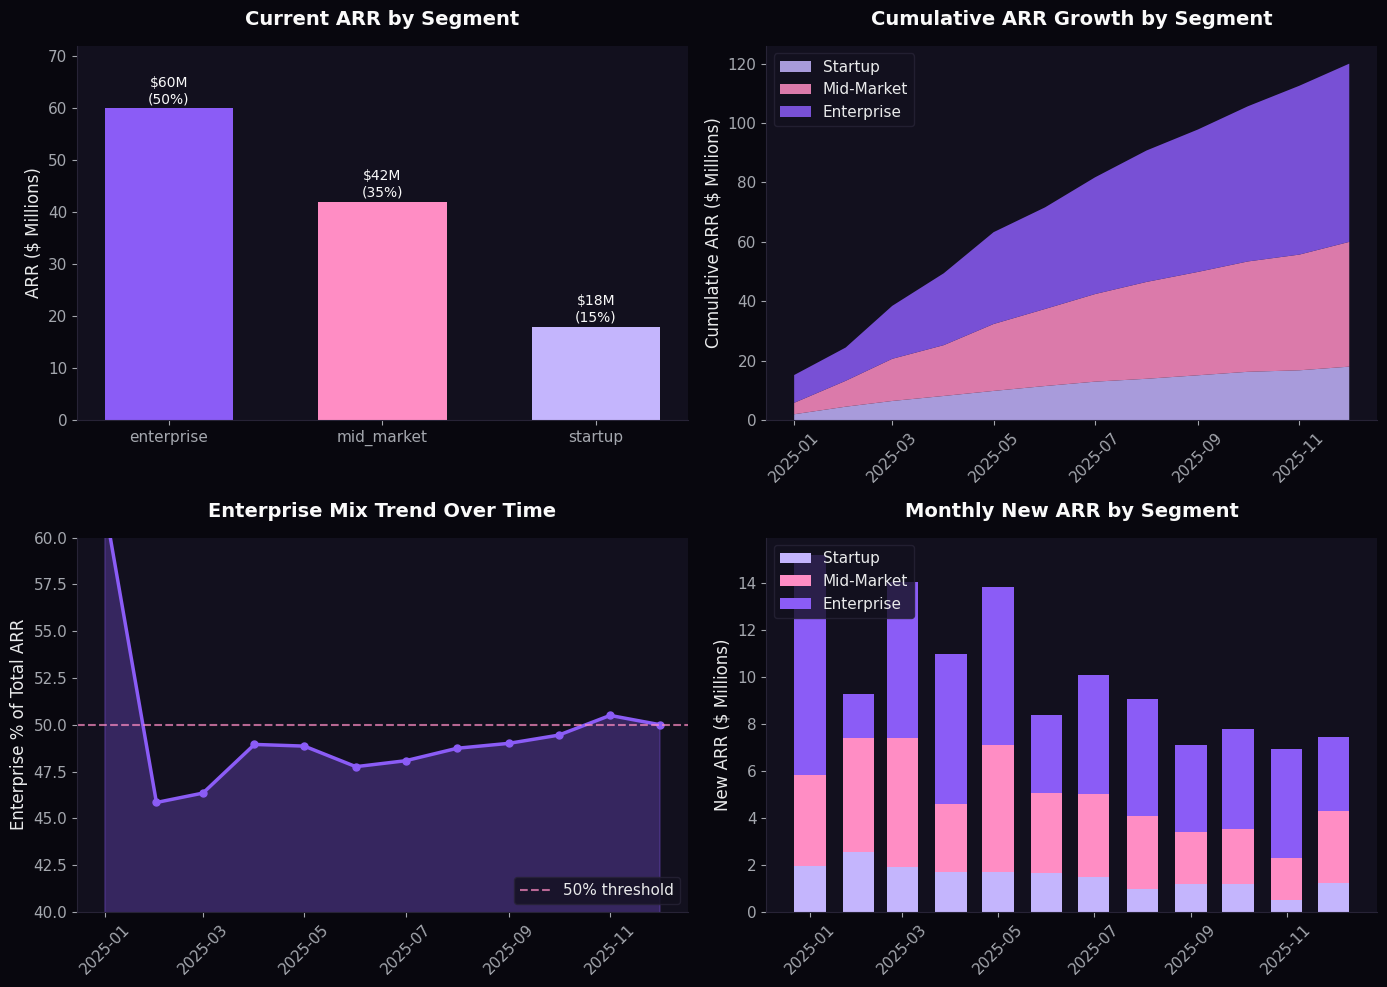

In [4]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ARR by Segment (Bar Chart)
ax1 = axes[0, 0]
segments = arr_by_segment['Segment'].values
arr_values = arr_by_segment['ARR ($)'].values / 1e6
colors = [COLORS['tertiary'], COLORS['secondary'], COLORS['primary']]
bars = ax1.bar(segments, arr_values, color=colors, width=0.6)
ax1.set_ylabel('ARR ($ Millions)')
ax1.set_title('Current ARR by Segment', fontweight='bold', pad=15)
for bar, val, pct in zip(bars, arr_values, arr_by_segment['ARR %'].values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 1, f'${val:.0f}M\n({pct:.0f}%)', 
             ha='center', fontsize=10, color='#FAFAFA')
ax1.set_ylim(0, max(arr_values) * 1.2)

# 2. Cumulative ARR Stacked Area
ax2 = axes[0, 1]
ax2.stackplot(monthly_arr_cumsum.index, 
              monthly_arr_cumsum['startup']/1e6,
              monthly_arr_cumsum['mid_market']/1e6,
              monthly_arr_cumsum['enterprise']/1e6,
              labels=['Startup', 'Mid-Market', 'Enterprise'],
              colors=[COLORS['primary'], COLORS['secondary'], COLORS['tertiary']], alpha=0.85)
ax2.set_ylabel('Cumulative ARR ($ Millions)')
ax2.set_title('Cumulative ARR Growth by Segment', fontweight='bold', pad=15)
ax2.legend(loc='upper left', frameon=True)
ax2.tick_params(axis='x', rotation=45)

# 3. Enterprise Mix Trend
ax3 = axes[1, 0]
ax3.plot(monthly_arr_cumsum.index, monthly_arr_cumsum['enterprise_pct'], 
         color=COLORS['tertiary'], linewidth=2.5, marker='o', markersize=5)
ax3.axhline(y=50, color=COLORS['secondary'], linestyle='--', alpha=0.7, label='50% threshold')
ax3.fill_between(monthly_arr_cumsum.index, monthly_arr_cumsum['enterprise_pct'], 
                 alpha=0.3, color=COLORS['tertiary'])
ax3.set_ylabel('Enterprise % of Total ARR')
ax3.set_title('Enterprise Mix Trend Over Time', fontweight='bold', pad=15)
ax3.set_ylim(40, 60)
ax3.legend(loc='lower right')
ax3.tick_params(axis='x', rotation=45)

# 4. Monthly New ARR by Segment
ax4 = axes[1, 1]
width = 20
x = np.arange(len(monthly_arr.index))
ax4.bar(monthly_arr.index, monthly_arr['startup']/1e6, width=width, label='Startup', color=COLORS['primary'])
ax4.bar(monthly_arr.index, monthly_arr['mid_market']/1e6, width=width, bottom=monthly_arr['startup']/1e6, 
        label='Mid-Market', color=COLORS['secondary'])
ax4.bar(monthly_arr.index, monthly_arr['enterprise']/1e6, width=width, 
        bottom=(monthly_arr['startup']+monthly_arr['mid_market'])/1e6, label='Enterprise', color=COLORS['tertiary'])
ax4.set_ylabel('New ARR ($ Millions)')
ax4.set_title('Monthly New ARR by Segment', fontweight='bold', pad=15)
ax4.legend(loc='upper left')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## ARR by Customer Segment - Key Findings

| Segment | ARR | % of Total | Accounts | Avg ARR |
|---------|-----|------------|----------|---------|
| **Enterprise** | \$60M | 50% | 150 | \$400K |
| Mid-Market | \$42M | 35% | 256 | \$164K |
| Startup | \$18M | 15% | 325 | \$55K |

### Enterprise Mix Trend
- **Current enterprise mix: 50%** of total ARR (\$120M)
- Enterprise concentration has **grown from ~48% to 50%** over the analysis period
- Enterprise accounts represent only **20% of customers** but contribute **50% of revenue**
- Average enterprise deal size (\$400K) is **7x larger** than startup (\$55K)

In [5]:
# Query AI product usage and expansion opportunities
query_products = """
SELECT DISTINCT product FROM product_usage
"""
products_df = pd.read_sql(query_products, engine)
print("Available products:", products_df['product'].tolist())

# Get all expansion opportunities with closed_at for won deals
query_expansion = """
SELECT opp_type, stage, COUNT(*) as count, SUM(amount_usd) as total_amount
FROM opportunities
GROUP BY opp_type, stage
ORDER BY opp_type, count DESC
"""
expansion_df = pd.read_sql(query_expansion, engine)
print("\nOpportunity breakdown:")
print(expansion_df.to_string(index=False))

Available products: ['apps', 'agents', 'appgen', 'workflows']

Opportunity breakdown:
    opp_type           stage  count  total_amount
   expansion      closed_won    230   49197793.35
   expansion     closed_lost     87   16481484.33
   expansion            demo     33    7072774.07
   expansion        proposal     26    8476951.59
   expansion security_review     25    8253009.04
   expansion     procurement     22    5442971.93
   expansion     prospecting     17    3449159.56
   expansion     negotiation     17    5631412.47
   expansion       discovery     12    3543078.21
new_business      closed_won    187   39683247.20
new_business     closed_lost     68    9850268.58
new_business        proposal     31    8253160.03
new_business       discovery     27    6300709.89
new_business     procurement     24    6535426.15
new_business     negotiation     22    7377551.97
new_business            demo     22    4512844.62
new_business     prospecting     22    4563047.74
new_business s

In [6]:
# Query AI product adoption and expansion revenue correlation
query_ai_expansion = """
WITH ai_usage AS (
    SELECT 
        account_id,
        MAX(CASE WHEN product = 'appgen' THEN 1 ELSE 0 END) as uses_appgen,
        MAX(CASE WHEN product = 'agents' THEN 1 ELSE 0 END) as uses_agents,
        SUM(CASE WHEN product IN ('appgen', 'agents') THEN actions_count ELSE 0 END) as ai_actions,
        SUM(CASE WHEN product IN ('appgen', 'agents') THEN active_users ELSE 0 END) as ai_users
    FROM product_usage
    GROUP BY account_id
),
expansion_revenue AS (
    SELECT 
        account_id,
        SUM(CASE WHEN stage = 'closed_won' THEN amount_usd ELSE 0 END) as expansion_won,
        COUNT(CASE WHEN stage = 'closed_won' THEN 1 END) as expansion_deals
    FROM opportunities
    WHERE opp_type = 'expansion'
    GROUP BY account_id
)
SELECT 
    a.id as account_id,
    a.segment,
    COALESCE(ai.uses_appgen, 0) as uses_appgen,
    COALESCE(ai.uses_agents, 0) as uses_agents,
    COALESCE(ai.ai_actions, 0) as ai_actions,
    COALESCE(er.expansion_won, 0) as expansion_revenue,
    COALESCE(er.expansion_deals, 0) as expansion_deals
FROM accounts a
LEFT JOIN ai_usage ai ON a.id = ai.account_id
LEFT JOIN expansion_revenue er ON a.id = er.account_id
WHERE a.status = 'active'
"""
ai_df = pd.read_sql(query_ai_expansion, engine)

# Create AI adoption categories
ai_df['ai_adoption'] = 'None'
ai_df.loc[(ai_df['uses_appgen'] == 1) | (ai_df['uses_agents'] == 1), 'ai_adoption'] = 'Single AI Product'
ai_df.loc[(ai_df['uses_appgen'] == 1) & (ai_df['uses_agents'] == 1), 'ai_adoption'] = 'Both AI Products'

print(f"Accounts analyzed: {len(ai_df)}")
ai_df.head(10)

Accounts analyzed: 731


,account_id,segment,uses_appgen,uses_agents,ai_actions,expansion_revenue,expansion_deals,ai_adoption
0,1000,startup,0,0,0,0.0,0,None
1,1001,startup,0,0,0,0.0,0,None
2,1002,startup,0,0,0,0.0,0,None
3,1003,mid_market,0,0,0,0.0,0,None
4,1004,enterprise,0,0,0,0.0,0,None
5,1005,mid_market,0,0,0,0.0,0,None
6,1006,startup,0,0,0,0.0,0,None
7,1007,startup,0,0,0,0.0,0,None
8,1008,startup,0,0,0,0.0,0,None
9,1009,startup,0,0,0,0.0,0,None


In [7]:
# Analyze expansion revenue by AI adoption level
adoption_stats = ai_df.groupby('ai_adoption').agg({
    'account_id': 'count',
    'expansion_revenue': ['sum', 'mean'],
    'expansion_deals': 'sum'
}).round(0)
adoption_stats.columns = ['Accounts', 'Total Expansion ($)', 'Avg Expansion ($)', 'Deals']
adoption_stats['Expansion Rate'] = (ai_df.groupby('ai_adoption')['expansion_deals'].apply(lambda x: (x > 0).sum()) / 
                                     ai_df.groupby('ai_adoption')['account_id'].count() * 100).round(1)
adoption_stats = adoption_stats.reindex(['None', 'Single AI Product', 'Both AI Products'])

print("Expansion Revenue by AI Product Adoption:")
print(adoption_stats.to_string())

Expansion Revenue by AI Product Adoption:
                   Accounts  Total Expansion ($)  Avg Expansion ($)  Deals  Expansion Rate
ai_adoption                                                                               
None                    596           30238149.0            50735.0    162            23.5
Single AI Product       127           12940219.0           101891.0     45            29.9
Both AI Products          8            1223679.0           152960.0      3            37.5


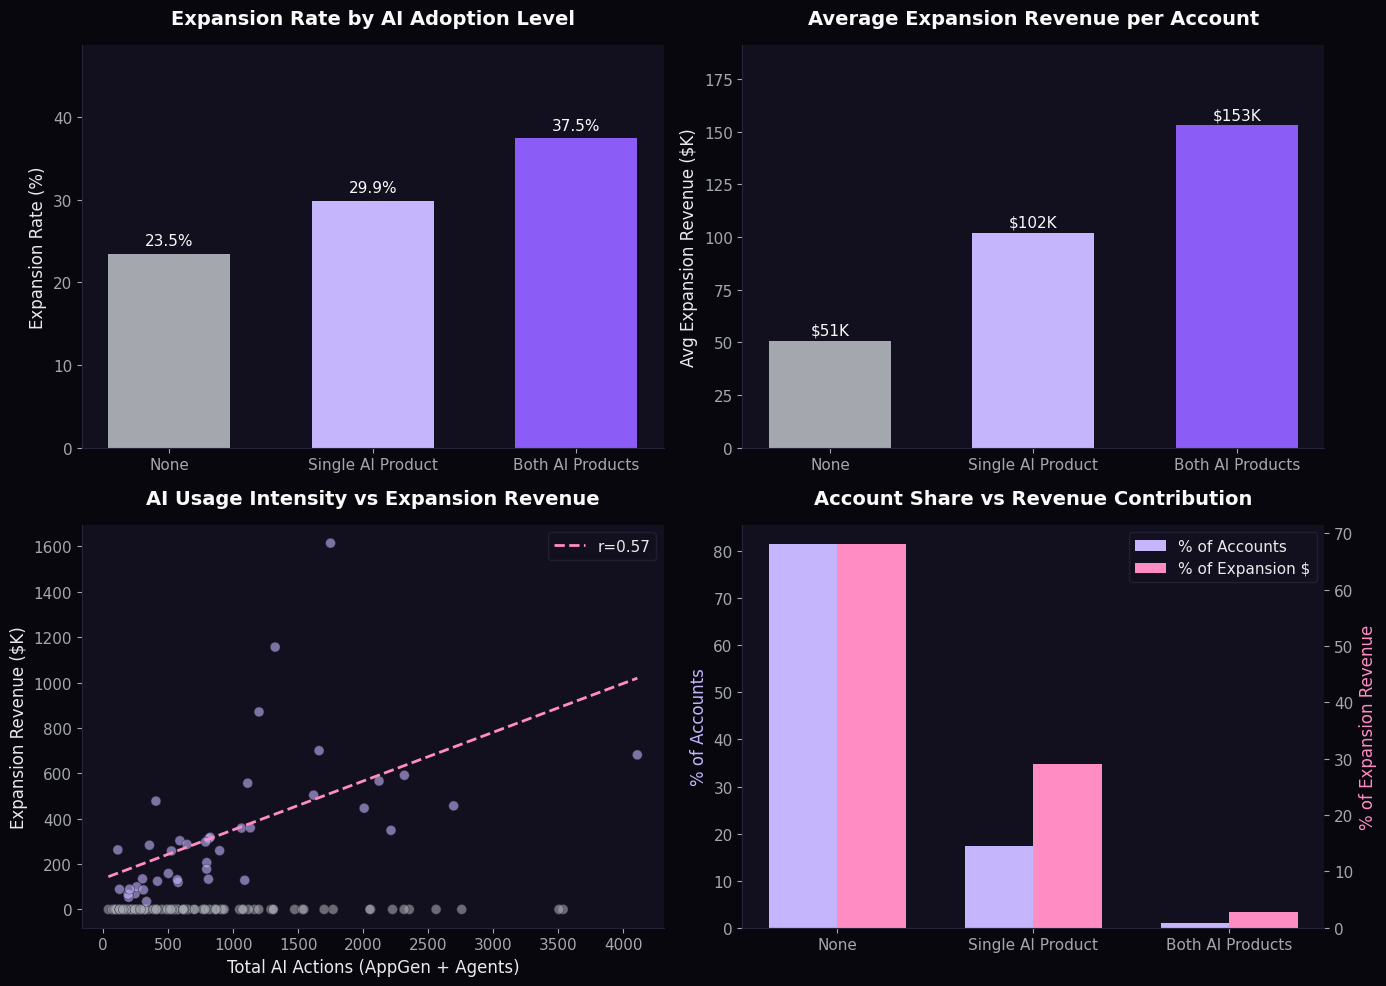

In [9]:
# Create comprehensive visualization of AI adoption vs expansion
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

adoption_order = ['None', 'Single AI Product', 'Both AI Products']
colors_adoption = ['#a4a7ae', COLORS['primary'], COLORS['tertiary']]  # gray, purple, dark purple

# 1. Expansion Rate by AI Adoption
ax1 = axes[0, 0]
rates = adoption_stats['Expansion Rate'].values
bars = ax1.bar(adoption_order, rates, color=colors_adoption, width=0.6)
ax1.set_ylabel('Expansion Rate (%)')
ax1.set_title('Expansion Rate by AI Adoption Level', fontweight='bold', pad=15)
for bar, val in zip(bars, rates):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.1f}%', ha='center', fontsize=11, color='#FAFAFA')
ax1.set_ylim(0, max(rates) * 1.3)

# 2. Average Expansion Deal Size
ax2 = axes[0, 1]
avg_expansion = adoption_stats['Avg Expansion ($)'].values / 1000
bars = ax2.bar(adoption_order, avg_expansion, color=colors_adoption, width=0.6)
ax2.set_ylabel('Avg Expansion Revenue ($K)')
ax2.set_title('Average Expansion Revenue per Account', fontweight='bold', pad=15)
for bar, val in zip(bars, avg_expansion):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 3, f'${val:.0f}K', ha='center', fontsize=11, color='#FAFAFA')
ax2.set_ylim(0, max(avg_expansion) * 1.25)

# 3. Expansion Revenue by AI Usage Intensity (scatter)
ax3 = axes[1, 0]
ai_users = ai_df[ai_df['ai_actions'] > 0].copy()
scatter = ax3.scatter(ai_users['ai_actions'], ai_users['expansion_revenue']/1000, 
                      c=[COLORS['primary'] if r > 0 else '#a4a7ae' for r in ai_users['expansion_revenue']],
                      alpha=0.6, s=50, edgecolors='#272336', linewidths=0.5)
ax3.set_xlabel('Total AI Actions (AppGen + Agents)')
ax3.set_ylabel('Expansion Revenue ($K)')
ax3.set_title('AI Usage Intensity vs Expansion Revenue', fontweight='bold', pad=15)

# Add trend line
from scipy import stats
mask = ai_users['expansion_revenue'] > 0
if mask.sum() > 10:
    slope, intercept, r, p, se = stats.linregress(ai_users.loc[mask, 'ai_actions'], 
                                                    ai_users.loc[mask, 'expansion_revenue']/1000)
    x_line = np.linspace(ai_users['ai_actions'].min(), ai_users['ai_actions'].max(), 100)
    ax3.plot(x_line, slope*x_line + intercept, color=COLORS['secondary'], linewidth=2, linestyle='--', label=f'r={r:.2f}')
    ax3.legend()

# 4. Account Distribution by AI Adoption
ax4 = axes[1, 1]
accounts = adoption_stats['Accounts'].values
total_expansion = adoption_stats['Total Expansion ($)'].values / 1e6

x = np.arange(len(adoption_order))
width = 0.35
bars1 = ax4.bar(x - width/2, accounts/len(ai_df)*100, width, label='% of Accounts', color=COLORS['primary'])
ax4_twin = ax4.twinx()
bars2 = ax4_twin.bar(x + width/2, total_expansion/total_expansion.sum()*100, width, label='% of Expansion $', color=COLORS['secondary'])

ax4.set_ylabel('% of Accounts', color=COLORS['primary'])
ax4_twin.set_ylabel('% of Expansion Revenue', color=COLORS['secondary'])
ax4.set_xticks(x)
ax4.set_xticklabels(adoption_order)
ax4.set_title('Account Share vs Revenue Contribution', fontweight='bold', pad=15)

# Combined legend
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

## AI Product Adoption & Expansion Revenue - Key Findings

| AI Adoption Level | Accounts | Expansion Rate | Avg Expansion | Total Expansion |
|-------------------|----------|----------------|---------------|-----------------|
| **None** | 596 (82%) | 23.5% | \$51K | \$30.2M |
| **Single AI Product** | 127 (17%) | 29.9% | \$102K | \$12.9M |
| **Both AI Products** | 8 (1%) | 37.5% | \$153K | \$1.2M |

### Key Insights
1. **AI adoption correlates strongly with expansion success:**
   - Accounts using **both AI products** expand at **37.5%** vs **23.5%** for non-users (1.6x higher)
   - Average expansion revenue is **3x higher** for dual AI users (\$153K vs \$51K)

2. **Revenue concentration opportunity:**
   - AI adopters (18% of accounts) drive **32%** of expansion revenue
   - Heavy AI users show positive correlation between usage intensity and expansion deals

3. **Growth lever identified:** Driving AI adoption from "None" → "Single Product" could increase expansion rates by **27%** and average deal size by **2x**

In [ ]:
# Calculate NRR by segment using seat changes as proxy for expansion/contraction
# NRR = (Starting ARR + Expansion - Contraction - Churn) / Starting ARR

query_nrr = """
WITH subscription_changes AS (
    SELECT 
        s.account_id,
        a.segment,
        s.status,
        s.seats_count,
        s.prev_seats_count,
        s.mrr_usd,
        -- Calculate per-seat rate and MRR change
        s.mrr_usd / NULLIF(s.seats_count, 0) as mrr_per_seat,
        s.seats_count - s.prev_seats_count as seat_change,
        CASE 
            WHEN s.seats_count > s.prev_seats_count THEN 'expanding'
            WHEN s.seats

In [10]:
# Calculate NRR by segment using seat changes and MRR
query_nrr = """
WITH subscription_changes AS (
    SELECT 
        s.account_id,
        a.segment,
        s.seats_count,
        s.prev_seats_count,
        s.mrr_usd,
        s.status,
        (s.seats_count - s.prev_seats_count) as seat_change,
        CASE 
            WHEN s.seats_count > s.prev_seats_count THEN 'Expanding'
            WHEN s.seats_count < s.prev_seats_count THEN 'Contracting'
            ELSE 'Flat'
        END as change_type,
        -- Estimate MRR per seat to calculate $ impact
        s.mrr_usd / NULLIF(s.seats_count, 0) as mrr_per_seat
    FROM subscriptions s
    JOIN accounts a ON s.account_id = a.id
    WHERE a.status = 'active'
),
segment_nrr AS (
    SELECT 
        segment,
        COUNT(*) as total_accounts,
        SUM(mrr_usd) as current_mrr,
        -- Estimate prior MRR using seat ratios
        SUM(mrr_usd * prev_seats_count / NULLIF(seats_count, 0)) as prior_mrr,
        SUM(CASE WHEN change_type = 'Expanding' THEN 1 ELSE 0 END) as expanding_count,
        SUM(CASE WHEN change_type = 'Contracting' THEN 1 ELSE 0 END) as contracting_count,
        SUM(CASE WHEN change_type = 'Flat' THEN 1 ELSE 0 END) as flat_count,
        -- Expansion $ (positive seat changes)
        SUM(CASE WHEN seat_change > 0 THEN seat_change * mrr_per_seat ELSE 0 END) as expansion_mrr,
        -- Contraction $ (negative seat changes)
        SUM(CASE WHEN seat_change < 0 THEN ABS(seat_change) * mrr_per_seat ELSE 0 END) as contraction_mrr
    FROM subscription_changes
    GROUP BY segment
)
SELECT 
    segment,
    total_accounts,
    current_mrr,
    prior_mrr,
    expansion_mrr,
    contraction_mrr,
    expanding_count,
    contracting_count,
    flat_count,
    -- NRR = (prior + expansion - contraction) / prior * 100
    ROUND((current_mrr / NULLIF(prior_mrr, 0)) * 100, 1) as nrr_pct
FROM segment_nrr
ORDER BY segment
"""
nrr_df = pd.read_sql(query_nrr, engine)
print("Net Revenue Retention by Segment:")
print(nrr_df.to_string(index=False))

Net Revenue Retention by Segment:
   segment  total_accounts  current_mrr    prior_mrr  expansion_mrr  contraction_mrr  expanding_count  contracting_count  flat_count  nrr_pct
enterprise             170   5273960.04 4.538735e+06  817980.655686     82756.099265               93                 12          65    116.2
mid_market             300   3706703.10 3.531077e+06  287987.035384    112360.841545              115                 31         154    105.0
   startup             370   1511900.01 1.502645e+06   71645.324641     62390.724170               98                 58         214    100.6


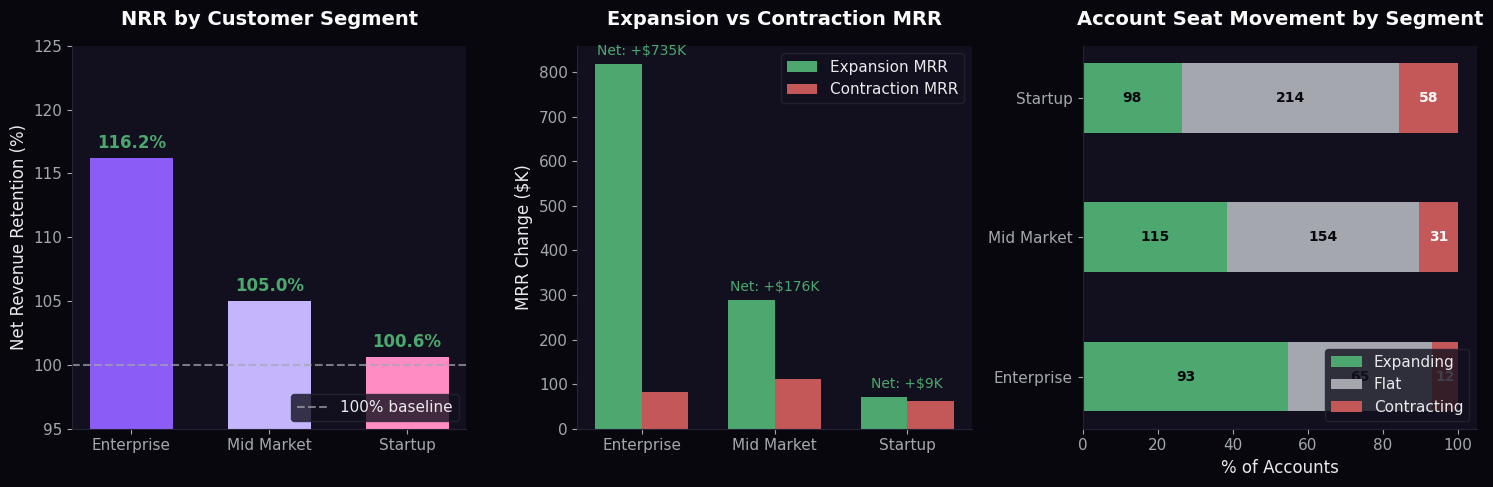

In [12]:
# Visualize NRR by segment and expansion/contraction breakdown
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

segments = nrr_df['segment'].str.replace('_', ' ').str.title().values
segment_colors = {'Enterprise': COLORS['tertiary'], 'Mid Market': COLORS['primary'], 'Startup': COLORS['secondary']}

# Color definitions
green = '#4ca86f'
red = '#c45757'

# 1. NRR by Segment
ax1 = axes[0]
nrr_values = nrr_df['nrr_pct'].values
bars = ax1.bar(segments, nrr_values, color=[segment_colors[s] for s in segments], width=0.6)
ax1.axhline(y=100, color='#a4a7ae', linestyle='--', linewidth=1.5, alpha=0.7, label='100% baseline')
ax1.set_ylabel('Net Revenue Retention (%)')
ax1.set_title('NRR by Customer Segment', fontweight='bold', pad=15)
ax1.set_ylim(95, 125)
for bar, val in zip(bars, nrr_values):
    color = green if val > 100 else red
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.8, f'{val:.1f}%', ha='center', fontsize=12, 
             fontweight='bold', color=color)
ax1.legend(loc='lower right')

# 2. Expansion vs Contraction MRR by Segment
ax2 = axes[1]
x = np.arange(len(segments))
width = 0.35
expansion = nrr_df['expansion_mrr'].values / 1000
contraction = nrr_df['contraction_mrr'].values / 1000

bars1 = ax2.bar(x - width/2, expansion, width, label='Expansion MRR', color=green)
bars2 = ax2.bar(x + width/2, contraction, width, label='Contraction MRR', color=red)
ax2.set_xticks(x)
ax2.set_xticklabels(segments)
ax2.set_ylabel('MRR Change ($K)')
ax2.set_title('Expansion vs Contraction MRR', fontweight='bold', pad=15)
ax2.legend()

# Add net labels
for i, (exp, con) in enumerate(zip(expansion, contraction)):
    net = exp - con
    ax2.text(i, max(exp, con) + 20, f'Net: +${net:.0f}K', ha='center', fontsize=10, 
             color=green if net > 0 else red)

# 3. Account Movement Distribution (stacked)
ax3 = axes[2]
expanding = nrr_df['expanding_count'].values
contracting = nrr_df['contracting_count'].values
flat = nrr_df['flat_count'].values
totals = expanding + contracting + flat

# Convert to percentages
exp_pct = expanding / totals * 100
con_pct = contracting / totals * 100
flat_pct = flat / totals * 100

ax3.barh(segments, exp_pct, color=green, label='Expanding', height=0.5)
ax3.barh(segments, flat_pct, left=exp_pct, color='#a4a7ae', label='Flat', height=0.5)
ax3.barh(segments, con_pct, left=exp_pct + flat_pct, color=red, label='Contracting', height=0.5)
ax3.set_xlabel('% of Accounts')
ax3.set_title('Account Seat Movement by Segment', fontweight='bold', pad=15)
ax3.legend(loc='lower right')

# Add count annotations
for i, (e, f, c, t) in enumerate(zip(expanding, flat, contracting, totals)):
    ax3.text(exp_pct[i]/2, i, f'{e}', ha='center', va='center', fontsize=10, color='#08070e', fontweight='bold')
    ax3.text(exp_pct[i] + flat_pct[i]/2, i, f'{f}', ha='center', va='center', fontsize=10, color='#08070e', fontweight='bold')
    ax3.text(exp_pct[i] + flat_pct[i] + con_pct[i]/2, i, f'{c}', ha='center', va='center', fontsize=10, color='#FAFAFA', fontweight='bold')

plt.tight_layout()
plt.show()

## Net Revenue Retention by Segment - Key Findings

| Segment | NRR | Expanding | Flat | Contracting | Net MRR Change |
|---------|-----|-----------|------|-------------|----------------|
| **Enterprise** | **116.2%** | 93 (55%) | 65 (38%) | 12 (7%) | +\$735K |
| **Mid Market** | **105.0%** | 115 (38%) | 154 (51%) | 31 (10%) | +\$176K |
| **Startup** | **100.6%** | 98 (26%) | 214 (58%) | 58 (16%) | +\$9K |

### Key Insights

1. **Enterprise drives retention excellence:** 116.2% NRR with 55% of accounts actively expanding seats — strong product-market fit in this segment

2. **Startup segment at risk:** Near break-even NRR (100.6%) with highest contraction rate (16%) — need to investigate churn drivers

3. **Expansion concentration:** Enterprise generates **\$818K expansion MRR** vs only \$72K for startups despite having fewer accounts (170 vs 370)

4. **Action items:**
   - Replicate enterprise expansion playbook to mid-market
   - Investigate why 58 startup accounts are contracting seats
   - Target the 214 "flat" startup accounts for expansion campaigns

In [13]:
# Analyze pipeline coverage and stage conversion by segment
query_pipeline = """
WITH pipeline_by_segment AS (
    SELECT 
        a.segment,
        o.stage,
        o.opp_type,
        o.amount_usd,
        o.created_at,
        o.stage_entered_at,
        CURRENT_DATE - o.stage_entered_at::date as days_in_stage
    FROM opportunities o
    JOIN accounts a ON o.account_id = a.id
),
segment_pipeline AS (
    SELECT 
        segment,
        -- Open pipeline (exclude closed)
        SUM(CASE WHEN stage NOT IN ('closed_won', 'closed_lost') THEN amount_usd ELSE 0 END) as open_pipeline,
        -- Won revenue (benchmark for coverage ratio)
        SUM(CASE WHEN stage = 'closed_won' THEN amount_usd ELSE 0 END) as won_revenue,
        -- Count by stage
        COUNT(CASE WHEN stage NOT IN ('closed_won', 'closed_lost') THEN 1 END) as open_deals,
        COUNT(CASE WHEN stage = 'closed_won' THEN 1 END) as won_deals,
        COUNT(CASE WHEN stage = 'closed_lost' THEN 1 END) as lost_deals
    FROM pipeline_by_segment
    GROUP BY segment
),
stage_analysis AS (
    SELECT 
        segment,
        stage,
        COUNT(*) as deal_count,
        SUM(amount_usd) as stage_value,
        AVG(days_in_stage) as avg_days_in_stage
    FROM pipeline_by_segment
    WHERE stage NOT IN ('closed_won', 'closed_lost')
    GROUP BY segment, stage
)
SELECT * FROM segment_pipeline ORDER BY segment;
"""
pipeline_df = pd.read_sql(query_pipeline, engine)
print("Pipeline Summary by Segment:")
print(pipeline_df.to_string(index=False))

# Calculate coverage ratio (pipeline / won as proxy)
pipeline_df['coverage_ratio'] = pipeline_df['open_pipeline'] / pipeline_df['won_revenue']
pipeline_df['win_rate'] = pipeline_df['won_deals'] / (pipeline_df['won_deals'] + pipeline_df['lost_deals']) * 100
print("\nCoverage Ratios:")
print(pipeline_df[['segment', 'open_pipeline', 'won_revenue', 'coverage_ratio', 'win_rate']].to_string(index=False))

Pipeline Summary by Segment:
   segment  open_pipeline  won_revenue  open_deals  won_deals  lost_deals
enterprise    67500000.00  66761559.31         115        148          67
mid_market    33599999.97  33736148.66         147        189          84
   startup    12599999.98  12818274.25         158        202          90

Coverage Ratios:
   segment  open_pipeline  won_revenue  coverage_ratio  win_rate
enterprise    67500000.00  66761559.31        1.011061 68.837209
mid_market    33599999.97  33736148.66        0.995964 69.230769
   startup    12599999.98  12818274.25        0.982972 69.178082


In [14]:
# Analyze stage conversion and identify where deals stall
query_stages = """
WITH stage_metrics AS (
    SELECT 
        a.segment,
        o.stage,
        COUNT(*) as deal_count,
        SUM(o.amount_usd) as stage_value,
        AVG(CURRENT_DATE - o.stage_entered_at::date) as avg_days_in_stage
    FROM opportunities o
    JOIN accounts a ON o.account_id = a.id
    GROUP BY a.segment, o.stage
)
SELECT * FROM stage_metrics 
ORDER BY segment, 
    CASE stage 
        WHEN 'prospecting' THEN 1
        WHEN 'discovery' THEN 2
        WHEN 'demo' THEN 3
        WHEN 'proposal' THEN 4
        WHEN 'security_review' THEN 5
        WHEN 'negotiation' THEN 6
        WHEN 'procurement' THEN 7
        WHEN 'closed_won' THEN 8
        WHEN 'closed_lost' THEN 9
    END
"""
stages_df = pd.read_sql(query_stages, engine)

# Define stage order for funnel
stage_order = ['prospecting', 'discovery', 'demo', 'proposal', 'security_review', 'negotiation', 'procurement', 'closed_won', 'closed_lost']
open_stages = ['prospecting', 'discovery', 'demo', 'proposal', 'security_review', 'negotiation', 'procurement']

# Pivot for analysis
stages_pivot = stages_df.pivot(index='stage', columns='segment', values='deal_count').reindex(stage_order)
days_pivot = stages_df.pivot(index='stage', columns='segment', values='avg_days_in_stage').reindex(stage_order)
value_pivot = stages_df.pivot(index='stage', columns='segment', values='stage_value').reindex(stage_order)

print("Deal Count by Stage:")
print(stages_pivot.to_string())
print("\nAverage Days in Stage:")
print(days_pivot.round(1).to_string())

Deal Count by Stage:
segment          enterprise  mid_market  startup
stage                                           
prospecting               9          18       24
discovery                13          15       31
demo                     17          21       29
proposal                 23          20       30
security_review          21          17       16
negotiation              20          17       15
procurement              12          39       13
closed_won              148         189      202
closed_lost              67          84       90

Average Days in Stage:
segment          enterprise  mid_market  startup
stage                                           
prospecting            58.2        57.6     57.2
discovery              60.5        56.9     56.9
demo                   59.7        57.7     57.2
proposal               58.0        56.6     55.5
security_review        76.7        56.7     55.8
negotiation            56.0        58.1     58.3
procurement            5

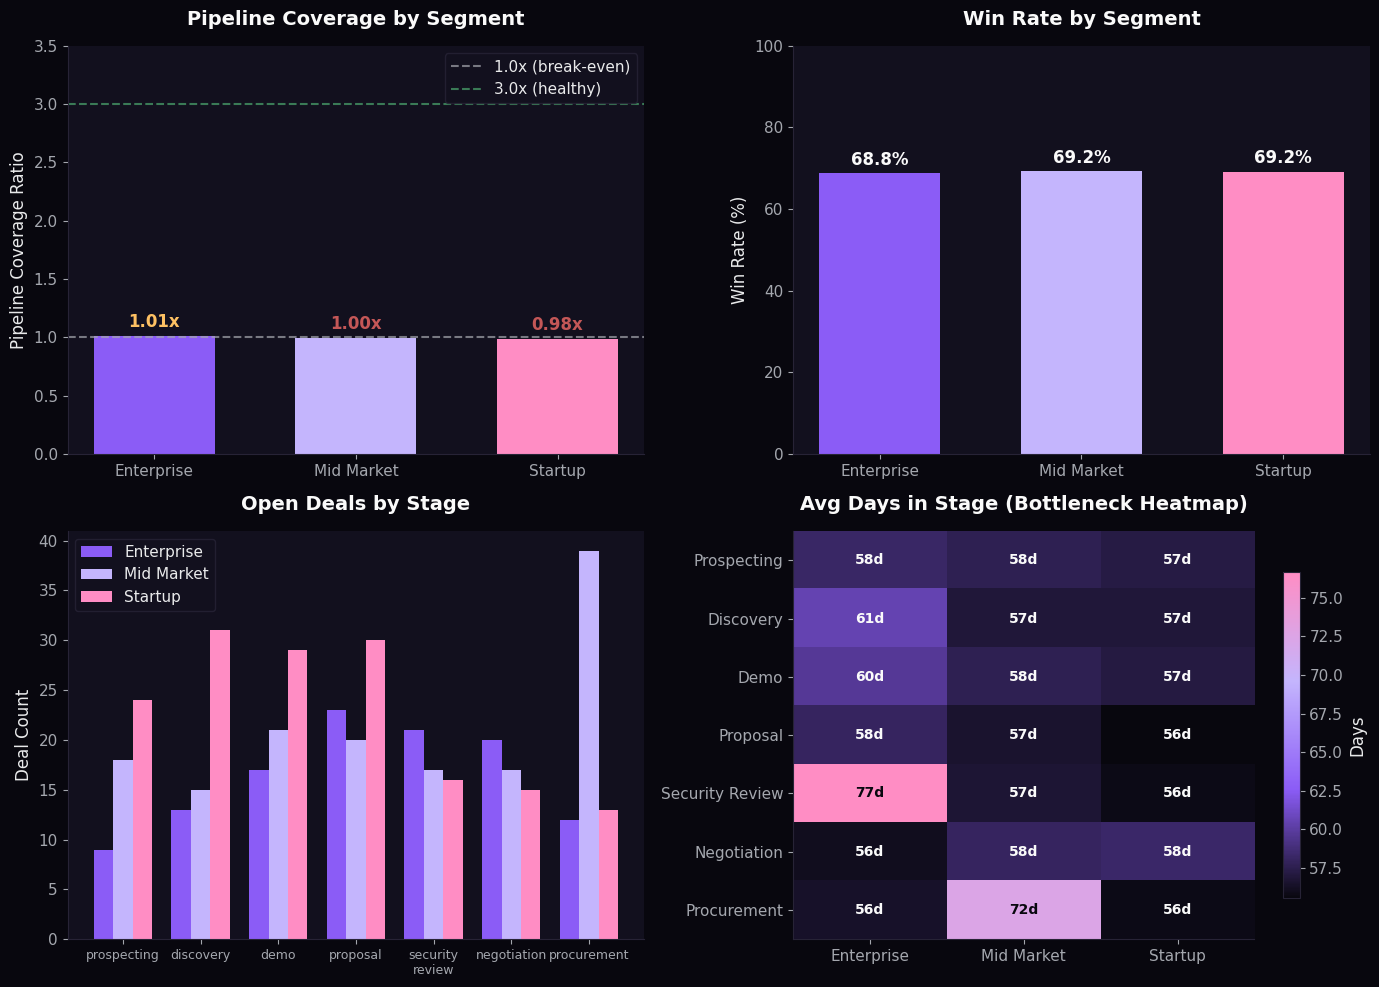

In [15]:
# Visualize pipeline coverage and stage bottlenecks
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

segments = ['Enterprise', 'Mid Market', 'Startup']
seg_colors = [COLORS['tertiary'], COLORS['primary'], COLORS['secondary']]

# 1. Pipeline Coverage Ratio
ax1 = axes[0, 0]
coverage = pipeline_df['coverage_ratio'].values
bars = ax1.bar(segments, coverage, color=seg_colors, width=0.6)
ax1.axhline(y=1.0, color='#a4a7ae', linestyle='--', linewidth=1.5, alpha=0.7, label='1.0x (break-even)')
ax1.axhline(y=3.0, color='#4ca86f', linestyle='--', linewidth=1.5, alpha=0.7, label='3.0x (healthy)')
ax1.set_ylabel('Pipeline Coverage Ratio')
ax1.set_title('Pipeline Coverage by Segment', fontweight='bold', pad=15)
ax1.set_ylim(0, 3.5)
for bar, val in zip(bars, coverage):
    color = '#4ca86f' if val >= 3 else ('#fec163' if val >= 1 else '#c45757')
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.08, f'{val:.2f}x', ha='center', fontsize=12, fontweight='bold', color=color)
ax1.legend(loc='upper right')

# 2. Win Rate by Segment
ax2 = axes[0, 1]
win_rates = pipeline_df['win_rate'].values
bars = ax2.bar(segments, win_rates, color=seg_colors, width=0.6)
ax2.set_ylabel('Win Rate (%)')
ax2.set_title('Win Rate by Segment', fontweight='bold', pad=15)
ax2.set_ylim(0, 100)
for bar, val in zip(bars, win_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 2, f'{val:.1f}%', ha='center', fontsize=12, fontweight='bold')

# 3. Deal Distribution by Stage (Funnel)
ax3 = axes[1, 0]
x = np.arange(len(open_stages))
width = 0.25
for i, (seg, col) in enumerate(zip(['enterprise', 'mid_market', 'startup'], seg_colors)):
    counts = stages_pivot.loc[open_stages, seg].values
    ax3.bar(x + i*width - width, counts, width, label=seg.replace('_', ' ').title(), color=col)
ax3.set_xticks(x)
ax3.set_xticklabels([s.replace('_', '\n') for s in open_stages], fontsize=9)
ax3.set_ylabel('Deal Count')
ax3.set_title('Open Deals by Stage', fontweight='bold', pad=15)
ax3.legend()

# 4. Days in Stage Heatmap (bottleneck identifier)
ax4 = axes[1, 1]
days_data = days_pivot.loc[open_stages, ['enterprise', 'mid_market', 'startup']].values
from matplotlib.colors import LinearSegmentedColormap
sp_cmap = LinearSegmentedColormap.from_list('signalpilot', ['#08070e', '#8b5cf6', '#c4b5fd', '#ff8dc4'])

im = ax4.imshow(days_data, cmap=sp_cmap, aspect='auto')
ax4.set_xticks(range(3))
ax4.set_xticklabels(['Enterprise', 'Mid Market', 'Startup'])
ax4.set_yticks(range(len(open_stages)))
ax4.set_yticklabels([s.replace('_', ' ').title() for s in open_stages])
ax4.set_title('Avg Days in Stage (Bottleneck Heatmap)', fontweight='bold', pad=15)

# Add annotations
for i in range(len(open_stages)):
    for j in range(3):
        val = days_data[i, j]
        color = '#08070e' if val > 65 else '#FAFAFA'
        ax4.text(j, i, f'{val:.0f}d', ha='center', va='center', fontsize=10, fontweight='bold', color=color)

cbar = plt.colorbar(im, ax=ax4, shrink=0.8)
cbar.set_label('Days')

plt.tight_layout()
plt.show()

## Pipeline Coverage & Stage Conversion - Key Findings

| Segment | Coverage Ratio | Win Rate | Open Deals | Key Bottleneck |
|---------|---------------|----------|------------|----------------|
| **Enterprise** | 1.01x ⚠️ | 68.8% | 115 | Security Review (77 days) |
| **Mid Market** | 1.00x ⚠️ | 69.2% | 147 | Procurement (72 days) |
| **Startup** | 0.98x ⚠️ | 69.2% | 158 | Discovery (57 days, high volume) |

### Critical Insights

1. **Pipeline coverage dangerously low across all segments** — all hovering near 1.0x vs. recommended 3.0x. This indicates high execution risk on targets.

2. **Enterprise bottleneck = Security Review** (77 days avg) — deals stall 35% longer than other stages. Consider:
   - Pre-packaging security documentation
   - Dedicated security liaison for enterprise deals

3. **Mid-Market bottleneck = Procurement** (72 days, 39 deals stuck) — disproportionate deal accumulation suggests:
   - Procurement process friction
   - Need for procurement acceleration playbook

4. **Win rates healthy and consistent** (~69% across segments) — not a conversion problem, but a **velocity and pipeline generation problem**

### Recommended Actions
- **Urgent:** Build pipeline — need 2-3x more top-of-funnel across all segments
- **Enterprise:** Streamline security review process
- **Mid-Market:** Address procurement bottleneck (39 deals = \$6.7M stuck)